# 3.2 Operators based on second derivative

In the previous notebooks we saw how to detect edges by looking at the gradient  image (first-derivative), but it is also possible to do that by analyzing the output of operators based on the second-derivative! 

As you may remember, first derivative operators try to detect edges by looking for high magnitude values of such derivatives. The figure below shows a one-dimensional continuous function $f(x)$ in (a) and its first derivative in (b), where we can see that the point corresponding to the highest intensity difference reaches a maximum value:

<center><img src="./images/second_derivative_of_continuous_function.PNG" width="700"><br /><br /></center>

The third figure (c) shows its second derivative, so we can check how such a value corresponds to... **a zero crossing!** That is, a second derivative yields a zero-crossing at points where the gradient presents a maximum, so we could detect edges looking for those crossings.

Unfortunately, things get a little tricky when moving to a 2D space (like images). Why? because depending on the orientation of the edge, this zero-crossing may go almost unnoticed (see, for example, d):

<center><img src="./images/second_derivatives_of_2D_functions.PNG" width="500"><br /><br /></center>

In this notebook we are going two explore two methods that face such issue and detect edges using the second derivative. These are:

- **Laplacian operator** (<a href="#321">Section 3.2.1</a>) 
- **LoG operator** (<a href="#322">Section 3.2.2</a>)

Additionally, we will also take a look at a widely used algorithm that is a combination of different techniques: the **Canny algorithm** (<a href="#323">Section 3.2.3</a>).

## Problem context - Edge detection for medical images

Unfortunately, you were not accepted (yet!) by the researching team at *Hospital Clínico* because the obtained results in the previous notebook were not as good as expected. Anyway, they have shown you the algorithms that they are currently using so you can learn for future opportunities. Let's have a look!

<center><img src="./images/hired.jpg" width="300"></center>

In [1]:
import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rcParams['figure.figsize'] = (15.0, 15.0)

images_path = './images/'

## 3.2.1 Laplacian operator <a id=321></a>

To face the previously posed issue about unnoticed edges due to the derivate orientation, the idea behind the Laplacian operator is to combine second derivatives in perpendicular directions. Thus, it is defined as:

$$ 
\nabla^2 f(i,j) =
\frac{\partial^2}{\partial x^2}f(i,j) + 
\frac{\partial^2}{\partial y^2}f(i,j)
$$

Note that, by definition, **it returns a scalar**, not a vector as in the gradient case. Indeed, the Laplacian is the trace of the *Hessian matrix*, which fully characterizes the second derivative of a function:

$$
H(f) =
\begin{bmatrix}
\frac{\partial f^2}{\partial x^2} & \frac{\partial}{\partial x}\frac{\partial f}{\partial y} \\
\frac{\partial f}{\partial y}\frac{\partial f}{\partial x} & \frac{\partial f^2}{\partial y^2}
\end{bmatrix}
$$

Compared with the first derivative-based edge detectors such as the Sobel operator, the Laplacian operator have a number of advantages:

- it is a linear operator,
- invariant to image orientation, and
- precise when localizing edges.

### Implementation
Now that we know the theory, let's have a look at how the Laplacian operator is implemented:

1. We start by considering first derivatives (OpenCV uses Sobel, but any alternative is valid): $\\[5pt]$

$$\frac{\partial f(x,y)}{\partial x} = f_x(x,y) \approx G_R(i,j) = f(i+1,j) - f(i,j) \\[5pt]$$

$$\frac{\partial f(x,y)}{\partial y} = f_x(x,y) \approx G_C(i,j) = f(i,j+1) - f(i,j) \\[5pt]$$

2. Then, take second derivatives using the previous definitions:

$$g = \frac{\partial f^2}{\partial x^2} = f_{xx}(x,y) \approx G_R(i,j) - G_R(i-1,j) = f(i+1,j) - 2f(i,j) + f(i-1,j) \\[5pt]$$

$$h = \frac{\partial f^2}{\partial y^2} = f_{yy}(x,y) \approx G_C(i,j) - G_C(i-1,j) = f(i,j+1) - 2f(i,j) + f(i,j-1) \\[10pt]$$

3. Finally, implement it as a convolution with a certain kernel, so $L[F(i,j)] = F(i,j) \otimes L(i,j)$. This would lead to the operation $L[F(i,j)] = (F(i,j) \otimes g) + (F(i,j) \otimes h)$, but thanks to the distributive property of convolution:$\\[10pt]$
$$\underbrace{f \otimes (g + h)}_{\text{One convolution}} 
= 
\underbrace{(f \otimes g) + (f \otimes h)}_{\text{Two convolutions}}\\[10pt]$$
We can obtain a kernel that carries out both convolutions at once!:

<div style="margin: 0 auto; text-align: center; display: table;">
<div>
    <p><center>g</center></p>
    <table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">-2</td>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
    </table> 
</div>
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle;"> $+$ </div>
<div>
    <p><center>h</center></p>    
    <table style = "display: table-cell; vertical-align: middle;">
    <tbody>
        <tr>
            <td style="border: 1px solid;">0</td>
            <td style="border: 1px solid;">1</td>
            <td style="border: 1px solid;">0</td>
        </tr>
        <tr>
            <td style="border: 1px solid;">0</td>
            <td style="border: 1px solid;" bgcolor="#81F7F3">-2</td>
            <td style="border: 1px solid;">0</td>
        </tr>
        <tr>
            <td style="border: 1px solid;">0</td>
            <td style="border: 1px solid;">1</td>
            <td style="border: 1px solid;">0</td>
        </tr>
    </tbody>
    </table> 
</div>    
    
<div style = "padding: 10px; display: table-cell; vertical-align: middle;"> = </div>
<div>
    <p><center>g+h=L</center></p>    
    <table style = "display: table-cell; vertical-align: middle;">
	<tbody>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;" bgcolor="#81F7F3">-4</td>
			<td style="border: 1px solid;">1</td>
		</tr>
		<tr>
			<td style="border: 1px solid;">0</td>
			<td style="border: 1px solid;">1</td>
			<td style="border: 1px solid;">0</td>
		</tr>
	</tbody>
    </table>
</div>   
    
</div>

### Zero-crossing

Note that the result of applying the Laplacian operator is not directly an edges image, but a second-derivative image. Recall that in the case of operators based on the first derivative we had to combine the two images returned by the gradient operator, and then apply a threshold to select edges. In this case, **it is needed an algorithm to detect zero-crossings** in the second-derivative (Laplacian) image in order to return a binary image of edges. 

An example of a simple zero-crossing algorithm could be:

1. Select a small positive number $th$ (threshold).
2. A pixel is labelled as an edge if in the Laplacian image:
    - its value is smaller than $-th$ and at least one of its neighbours is bigger that $th$, or
    - its value is bigger than $th$ and at least one of its neighbours is smaller than $-th$.
    
**Advantages:**
- Zero crossing produces a closed (or almost closed) contour, and
- it provides edges of 1-pixel width!    

**Limitations**
- Unfortunately, the Laplacian operator is very sensitive to noise, resulting in a poor edge detection. Solution: If the image is blurred using a Gaussian filter before applying the Laplace operator, we can partially solve the noise problem. If this is done, the resultant o is called **LoG (Laplacian of Gaussian)**.

## 3.2.2 LoG operator <a id=322></a>

So, the LoG operator first smoothes the image, and then applies the Laplacian operator (or viceversa, it's conmutative!). Considering the convolution properties:

$$
\nabla^2[f(x,y)\otimes g_\sigma(x,y)] 
=
f(x,y) \otimes \nabla^2[g_\sigma(x,y)]
= f(x,y) \otimes LoG_\sigma(x,y)
$$

LoG is an isotropic operator, that is, it keeps radial symmetry. In this way, it is assumed that the covariance in both image dimensions is the same! Mathematically it is expressed as:

$$LoG_\sigma (x,y) = 
\frac{1}{\pi \sigma^4}
\left[ \frac{x^2+y^2}{2 \sigma^2} -1 \right] \exp^{-\frac{x^2+y^2}{2 \sigma^2}}
=
\frac{1}{\pi \sigma^4}
\left[ \frac{r^2}{2 \sigma^2} -1 \right] \exp^{-\frac{r^2}{2 \sigma^2}}
= LoG_\sigma(r^2)
$$

**Let's print the LoG operator!**

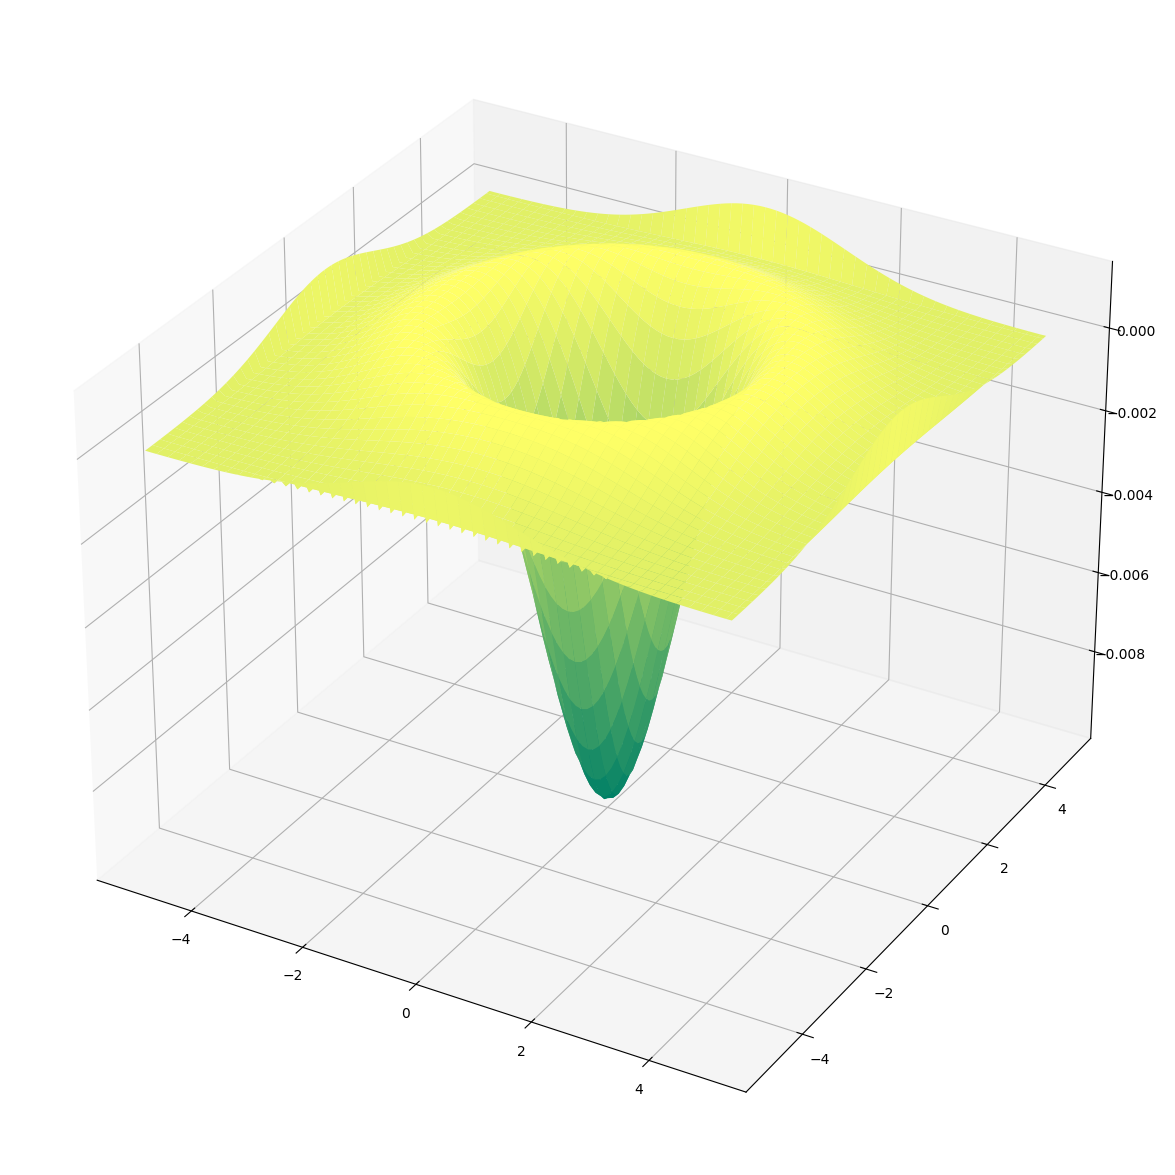

In [2]:
# Gauss filter
v = np.arange(-5,5,0.1)
X, Y = np.meshgrid(v,v)
covar = np.array([[2, 0],[0, 2]]) ## Assuming no correlation between X and Y
gauss_filter = np.exp(-0.5*(X**2/covar[0][0]+Y**2/covar[1][1])) 

# Laplace filter
laplace_filter = np.array(([[0,1,0],[1,-4,1],[0,1,0]]), dtype="float")

# LoG operator
LoG = cv2.filter2D(gauss_filter, -1, laplace_filter)

# Plot it!
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,LoG,cmap='summer', edgecolor='none');

As a side note, the LoG operator is not separable. However, it can be implemented as **DoG (Difference of Gaussians)**, a sum of separable operators, reducing its complexity from $O(N^2)$ to $O(4N)$. The DoG is defined as:

$$
DoG_{\sigma_1\sigma_2}(x,y) = 
g_{\sigma_1}(x,y) - g_{\sigma_2}(x,y) =
g_{\sigma_1}(x)g_{\sigma_1}(y) - g_{\sigma_2}(x) g_{\sigma_2}(y)
$$

Giving the ratio $\sigma_1 / \sigma_2 = 1.6$ the best approximation of LoG. This complexity reduction approach is employed, for example, in the popular SIFT keypoint detector, as we will see in following notebooks.

### Limitations

- It is computationally costly,
- it doesn't provide any information about edge orientations,
- the output contains negative and non-integer values, so for display purposes the image should be normalized to the range 0-255,
- it is needed a zero-crossing method, and
- it tends to round object corners (more heavily as $\sigma$ grows).

### Experiencing Laplacian and LoG operators 

Now that we are almost experts in the Laplacian and LoG operators, let's play a bit with them!

### **<span style="color:green"><b><i>ASSIGNMENT 1a: Applying Gaussian smoothing</i></b></span>**

First, complete the function `gaussian_smoothing()` that:
1. blurs an image using a Gaussian filter, then
2. normalizes it to leverage the full range of values $[0, \dots, 255]$ (this is just a way to process the image in order to increase its contrast), and 
3. finally returns the resulting image.

Interesting functions:
- For normalization you can use [`cv2.normalize()`](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd). 

In [3]:
# ASSIGNMENT 1a
# Implement a function that blurres an input image using a Gaussian filter and then normalizes it.
def gaussian_smoothing(image, sigma, w_kernel):
    """ Blur and normalize input image.   
    
        Args:
            image: Input image to be binarized
            sigma: Standard deviation of the Gaussian distribution
            w_kernel: Kernel aperture size
                    
        Returns: 
            smoothed_norm: Blurred image
    """   
    # Write your code here!
    
    # Define 1D kernel
    s=sigma
    w=w_kernel
    kernel_1D = np.array([gaussian_bell(x, s) for x in range(-w,w+1)])
    
    # Apply distributive property of convolution
    vertical_kernel = kernel_1D.reshape(2*w+1,1)
    horizontal_kernel = kernel_1D.reshape(1,2*w+1)   
    gaussian_kernel_2D = signal.convolve2d(vertical_kernel, horizontal_kernel)   
    
    # Blur image
    smoothed_img = cv2.filter2D(image, cv2.CV_8U, gaussian_kernel_2D)
    
    # Normalize to [0 254] values
    smoothed_norm = np.array(image.shape)
    smoothed_norm = cv2.normalize(smoothed_img, None, 0, 255, cv2.NORM_MINMAX) # Leave the second argument as None
    
    return smoothed_norm

def gaussian_bell(x, sigma):
    result = (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x**2)/(2*(sigma**2)))
    return result

### **<span style="color:green"><b><i>ASSIGNMENT 1b: Detecting edges with Laplacian and LoG</i></b></span>**

Now, we are going to see the differences between the Laplacian and LoG operators. For that complete the `laplace_testing()` function which:

1. applies the Laplacian operator to the input image and 
2. to a blurred version of the input image (use the previously implemented function `gaussian_smoothing()` to smooth it). Notice that applying the Laplacian operator after smoothing the image is equivalent to applying the LoG operator.
3. Finally displays both images along with the original one in a 1x3 plot. 

This function uses as inputs: 
- an image to be processed, 
- the size of the Laplacian filter (should be odd), and 
- the parameters of the Gaussian filter.

Note that it would possible to reduce the computation time by precomputing LoG (as commented above). This is convolving the Laplacian and Gaussian filters instead of applying them separately.

Interesting functions:
- OpenCV defines the Laplace operator as [cv2.Laplacian()](https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html).

In [4]:
# ASSIGNMENT 1b
# Implement a function that applies the Laplacian operator to the input image and to a blurred version of it. 
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def laplace_testing(image, size_Laplacian, sigma, w_gaussian):
    """ Apply Laplacian and Log operators to an image.   
    
        Args:
            image: Input image to be binarized
            size_Laplacian: size of Laplacian kernel (odd)
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """  
    # Write your code here!
    
    # Blur image
    blurred_img = gaussian_smoothing(image, sigma, w_gaussian)
    
    # Apply Laplacian to the original image
    laplacian = cv2.Laplacian(image, cv2.CV_8U, ksize=size_Laplacian)
    
    # Aplay Laplacian to the blurred image
    laplacian_blurred = cv2.Laplacian(blurred_img, cv2.CV_8U, ksize=size_Laplacian)
    
    # Show initial image
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show laplacian
    plt.subplot(132)
    plt.imshow(laplacian, cmap='gray')
    plt.title('Laplacian without blurring')
    
    # Show LoG
    plt.subplot(133)
    plt.imshow(laplacian_blurred, cmap='gray')
    plt.title('Laplacian blurred (LoG)')

It is time to try this method to our medical images and play with interactive parameters.$\\[5pt]$      

In [5]:
# Read an image
image = cv2.imread(images_path + 'medical_3.jpg', 0)

# Interact with the parameters!
interact(laplace_testing, image=fixed(image), size_Laplacian=(1,7,2), sigma=(1,3,0.1), w_gaussian=(1,3,1));

interactive(children=(IntSlider(value=3, description='size_Laplacian', max=7, min=1, step=2), FloatSlider(valu…

In [6]:
#If the gaussian_smothing() fuction returned the gaussian kernel instead of the blurred image we could convolve 
#the laplacian image and the gaussian kernel to reduce computation time

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer the following questions**:

- Could be the Laplacian applied without a previous blurring? Does this have any drawback?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Technically it can be applied but there is no point in it, the Laplacian operator is very sensitive to noise so this would result in a poor edge detection.</i></p>
    
- Are the images obtained in the previous function *edge images*?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>No, they are second-derivative images.</i></p>   
    
- If not, what would be needed for obtaining the edges from those images?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>We need an algorithm to detect zero-crossings in the second-derivative (Laplacian) image in order to return a binary image of edges.</i></p>   

## 3.2.3 The Canny algorithm <a id=323></a>

The Canny edge detector<sup>[[1]](#cite1)</sup> is an algorithm that combines a number of techniques: 
- the DroG operator, 
- non-maxima suppression, and 
- hysteresis. 

It was designed to be a good detector, yield a good localization, and to provide a single response!

This algorithm consists of the following steps:

1. **Noise filtering and gradient image**. Apply the DroG operator to reduce noise and obtain a gradient image.$\\[5pt]$

2. **Non-maximum suppression**. This removes pixels that are not considered to be part of an edge. Typically, the gradient image obtained after using DroG presents thick edges. The idea is to keep only those pixels that are maximum within their neighborhood in the direction of the gradient, suppressing the rest of them. Hence, only thin lines (candidate edges) will remain. For that:

     - We consider 4 main directions or *angular sectors*: $[0,45]$, $[45,90]$, $[90,135]$, $[135,180]$. The gradient angle $\theta[i,j]$ is approximated by where it lays. 
     - A 3x3 filter is moved over the gradient image $G[i,j]$ at each pixel, and it suppresses the edge strength of the center pixel (for example by setting its value to 0) if its magnitude is not greater than the magnitude of the two neighbors in the gradient direction. This way we have a single response at each edge.

<center><img src="./images/canny_nonmaxima.png" width="800"></center>

3. **Hysteresis**: The final step, for which the Canny algorithm uses two thresholds (upper and lower) to determine edge pixels:

    - If the grey level of a candidate pixel of the gradient image is higher than the upper threshold, the pixel is accepted as an edge.
    - If the grey level of a candidate pixel of the gradient image is below the lower threshold, then it is rejected.
    - If the grey level of a candidate pixel of the gradient image is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold and rejected otherwise.
   
<img src="./images/hysteresis.png" width="800">

This algorithm can be executed repeatedly with different levels of smoothing (changing the sigma of the DroG operator). Different sigmas produce edges at different spatial features.

### **<span style="color:green"><b><i>ASSIGNMENT 2: The enormously popular Canny algorithm</i></b></span>**

Complete `canny_testing()`, which applies the Canny algorithm. Note that OpenCV Canny's implementation does not apply Gaussian smoothing, but directly applies Sobel. This gives to us the opportunity to:

1. check the performance of this technique by considering the initial image and a smoothed version of it. *Note: use our popular `gaussian_smoothing()` function for blurring the image*
2. After this, display both resulting images along the original one. 

This function takes as arguments: 
- an image, 
- both lower and upper Canny thresholds, and 
- the parameters of the Gaussian filter.

Interesting functions:
- OpenCV implements the Canny algorithm in [cv2.Canny()](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny).

In [7]:
# ASSIGNMENT 2
# Implement a function that applies the Canny operator to an input image and to a blurred version of it. 
# Display a 1x3 plot with the original image and the two resulting edge images.
# Inputs: image, size of the Laplacian kernel, sigma and size of the Gaussian kernel
def canny_testing(image, lower_threshold, upper_threshold, sigma, w_gaussian):
    """ Apply Canny algorithm to an image.   
    
        Args:
            image: Input image to be binarized
            lower_threshold: bottom value for hysteresis
            upper_threshold: top value for hysteresis
            sigma: Standard deviation of the Gaussian distribution
            w_gaussian: Gaussian kernel aperture size
    """  
    
    # Smooth image
    blurred_img = gaussian_smoothing(image,sigma,w_gaussian)
    
    # Apply Canny to original image
    canny = cv2.Canny(image,lower_threshold,upper_threshold)
    
    # Apply Canny to blurred image
    canny_blurred = cv2.Canny(blurred_img,lower_threshold,upper_threshold)

    # Show initial image
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Original image')
    
    # Show Canny without blurring
    plt.subplot(132)
    plt.imshow(canny, cmap='gray')
    plt.title('Canny without smoothing')
    
    # Show Canny with blurring
    plt.subplot(133)
    plt.imshow(canny_blurred, cmap='gray')
    plt.title('Canny smoothed')

Among the multiple parameters of this algorithm, it is interesting to check its performance with different levels of smoothing (changing the sigma of the DroG operator). As commented, different sigma produces edges at different spatial features. **Try the effect of this and other parameters** playing with the interactive parameters in the following code cell. You can also try with your own images.

In [8]:
# Read an image
image = cv2.imread(images_path + 'medical_2.jpg', 0)

# Interact with the parameters
interact(canny_testing, image=fixed(image), lower_threshold=(0,260,20), upper_threshold=(0,260,20), sigma=(1,3,0.1), w_gaussian=(1,3,1));

interactive(children=(IntSlider(value=120, description='lower_threshold', max=260, step=20), IntSlider(value=1…

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now, **answer following questions**:

- Could Canny be applied without a previous blurring? Which are the consequences of this?
  
    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Yes but the noise would produce several detection errors, detecting unwanted borders.</i></p>
    
- What is a *good* value for both, lower and upper thresholds? Would these values be the same for any input image?
  
    <p style="margin: 4px 0px 0px 5px; color:blue"><i>40-60 for the lower threshold and 100-120 for the upper one are good values in this case. This values would not work for any input as each image needs it's own analysis (this doesn't mean this values wouldn't work with any other image, it means the woulnd't work with every image)</i></p>  
    
- Now that you have tried a good number of edge detection methods, **which one is your favorite, and why?**

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>My favorite detection method is the Canny algorithm as it is very resilient to noise and is the one that produces the best results with less errors</i></p>  

## Conclusion

Terrific! You finished this notebook, that includes information about:

- Laplacian and LoG operators and the importance of smoothing, and
- how the Canny algorithm is implemented and how to use it.

## Curiosity

The Canny algorithm is a well known algorithm in the computer vision field. It is used in a lot of modern technologies. However, the original paper was published in 1986 by John Canny<sup>[[1]](#cite1)</sup>.

## References

<a name="myfootnote1">[1]</a>: CANNY, John. [A computational approach to edge detection.](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwiU9uyiganoAhWNDWMBHducCvsQFjAJegQIBhAB&url=http%3A%2F%2Fciteseerx.ist.psu.edu%2Fviewdoc%2Fdownload%3Fdoi%3D10.1.1.420.3300%26rep%3Drep1%26type%3Dpdf&usg=AOvVaw3tsKoxnc3qnS7bji3HmvQc). IEEE Transactions on pattern analysis and machine intelligence, 1986, no 6, p. 679-698.